In [68]:
import torch.nn as nn
from torch import optim 
from torchvision import transforms
import torch.nn.functional as F 
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import torch 
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
import time
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from xgboost import XGBRFClassifier

In [4]:
os.chdir("/mnt/c/Users/Johan/Documents/ITligence")
print("Current working directory:", os.getcwd())

Current working directory: /mnt/c/Users/Johan/Documents/ITligence


# Create New Directory With Train And Test Images

In [30]:
def create_train_test_split(original_dataset_dir, work_dir, classes, test_size=0.2, random_state=42):
    # Define the new dataset directory
    base_dir = os.path.join(work_dir, 'splitted_dataset')
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')

    # Create directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for class_name in classes:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Split data and copy files
    for class_name in classes:
        class_dir = os.path.join(original_dataset_dir, class_name)
        images = os.listdir(class_dir)
        
        # Split images into training and testing sets
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=random_state)
        
        # Copy images to train folder
        for image in train_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(train_dir, class_name, image)
            shutil.copyfile(src, dst)
        
        # Copy images to test folder
        for image in test_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(test_dir, class_name, image)
            shutil.copyfile(src, dst)

    print('Dataset split into train and test sets in the working directory.')

# Specify the paths and classes /mnt/c
original_dataset_dir = "/mnt/c/Users/Johan/Documents/Tetration/datasets/FaceMask"  # Replace with your original dataset path
work_dir = os.getcwd()
classes = ['with_mask', 'without_mask']  # Replace with your actual class names

# Check if the original dataset directory exists
if not os.path.exists(original_dataset_dir):
    print(f"The directory {original_dataset_dir} does not exist.")
else:
    create_train_test_split(original_dataset_dir, work_dir, classes)


Dataset split into train and test sets in the working directory.


In [5]:
np_embedding = np.load("data/uncleaned_data/npy_BiasData_UnmodifiedTokenEmbedding1-100_paraphrase-MiniLM-L6-v2.npy")
JerryWeiData = pd.read_csv("data/uncleaned_data/JerryWeiAIData/train_orig.csv")
JerryWeiData = JerryWeiData["label"][1:100]

KeyboardInterrupt: 

In [194]:
JerryWeiData = torch.tensor(np.array(JerryWeiData))

# Assuming max_seq_length is 68 (the sequence length of the longest sentence)
max_seq_length = np_embedding.shape[1]

# Expand the labels tensor to match the sequence length
expanded_labels = JerryWeiData.unsqueeze(1).expand(-1, max_seq_length)


In [200]:
np_embedding.shape

(99, 68, 384)

In [214]:
train_embeddings = torch.tensor(np_embedding[1:80])
test_embeddings = torch.tensor(np_embedding[80:100])
train_labels = torch.tensor(expanded_labels[1:80])
test_labels = torch.tensor(expanded_labels[80:100])

train_data = TensorDataset(train_embeddings, train_labels)
test_data = TensorDataset(test_embeddings, test_labels)

/tmp/ipykernel_582329/520261732.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(expanded_labels[1:80])
/tmp/ipykernel_582329/520261732.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(expanded_labels[80:100])


In [206]:
train_embeddings.shape

torch.Size([79, 68, 384])

# Clustering to Reduce Size of embeddings

In [94]:
np_embedding = np.load("data/cleaned_data/npy_BiasData_5000-per-class-SentenceEmbedding_paraphrase-MiniLM-L6-v2.npy")
np_labels = np.load("data/cleaned_data/npy_BiasData_5000-per-class-labels_paraphrase-MiniLM-L6-v2.npy")

In [95]:
np_embedding.shape

(55000, 384)

Perform KNN to reduce size, and retain labels

In [ ]:
num_clusters = round(np_embedding.shape[0] / 2)  # original size divided by two

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(np_embedding)

# Get cluster centers (centroids) as representative embeddings
cluster_centers = kmeans.cluster_centers_

# Compute distances from each cluster center to all original embeddings
distances = cdist(cluster_centers, np_embedding)

# Find the index of the closest original embedding for each cluster center
closest_indices = np.argmin(distances, axis=1)

# Assign the label of the closest original embedding to each cluster center
cluster_center_labels = np_labels[closest_indices]

# Output the reduced embeddings and their corresponding labels
reduced_embeddings = cluster_centers
reduced_labels = cluster_center_labels

In [16]:
reduced_labels.shape

(550,)

In [17]:
np.save("data/cleaned_data/npy_BiasData_KNN-50-per-class-SentenceEmbedding_paraphrase-MiniLM-L6-v2.npy", reduced_embeddings)
np.save("data/cleaned_data/npy_BiasData_KNN-50-per-class-labels_paraphrase-MiniLM-L6-v2.npy", reduced_labels)

In [97]:
X_train, X_val, y_train, y_val = train_test_split(np_embedding,
                                                  np_labels,
                                                  test_size=0.2)

# Train XGBooster Model on "Reduced" Embeddings


In [108]:
xgb_gpu = XGBRFClassifier(
    n_estimators=100,         # Number of trees
    max_depth=10,             # Maximum depth per tree
    learning_rate=0.1,        # Learning rate
    subsample=0.8,            # Fraction of samples used per tree
    colsample_bynode=0.8,     # Fraction of features used per node
    tree_method='gpu_hist',   # Use GPU for training
    random_state=42           # For reproducibility
)

xgb_gpu.fit(X_train, y_train)


/home/carlviggo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:49:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=10, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=250, n_jobs=None,
                num_parallel_tree=None, objective='multi:softprob',
                random_state=42, ...)

In [109]:
y_pred = xgb_gpu.predict(X_val)

/home/carlviggo/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:57:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [110]:
val_accuracy = np.mean(y_pred == y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.2261


In [111]:
from sklearn.metrics import confusion_matrix, classification_report

class_report = classification_report(y_val, y_pred)

print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.25      0.24       974
           1       0.26      0.30      0.28      1002
           2       0.17      0.20      0.18       931
           3       0.18      0.13      0.15      1001
           4       0.20      0.13      0.16      1001
           5       0.27      0.31      0.29      1067
           6       0.20      0.23      0.21       976
           7       0.26      0.29      0.27      1054
           8       0.15      0.19      0.17       974
           9       0.38      0.37      0.37      1035
          10       0.13      0.07      0.09       985

    accuracy                           0.23     11000
   macro avg       0.22      0.22      0.22     11000
weighted avg       0.22      0.23      0.22     11000



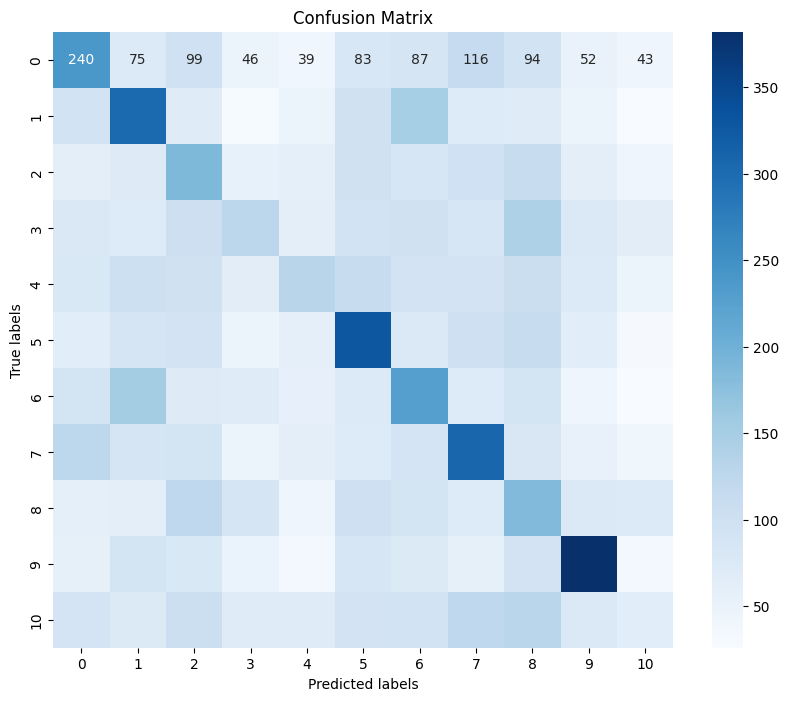

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", 
            xticklabels=range(11), yticklabels=range(11))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

Map together from ideology

In [113]:
# Define a function to map individual labels to broader categories
def map_to_ideology(label):
    if label in [0, 1, 2, 3, 4]:   # Liberal
        return 'Liberal'
    elif label == 5:               # Neutral
        return 'Neutral'
    elif label in [6, 7, 8, 9, 10]: # Conservative
        return 'Conservative'
    else:
        raise ValueError(f"Unexpected label: {label}")

# Apply the mapping to your true labels and predictions
y_val_ideology = np.array([map_to_ideology(label) for label in y_val])
y_pred_ideology = np.array([map_to_ideology(label) for label in y_pred])


In [114]:
# Create a confusion matrix for the mapped labels
conf_matrix_ideology = confusion_matrix(y_val_ideology, y_pred_ideology, labels=['Liberal', 'Neutral', 'Conservative'])

print("Confusion Matrix (Mapped Ideologies):")
print(conf_matrix_ideology)

# Generate a classification report for the mapped labels
class_report_ideology = classification_report(y_val_ideology, y_pred_ideology)

print("Classification Report (Mapped Ideologies):")
print(class_report_ideology)

print("Validation accuracies concatenated")
val_accuracy_conc = np.mean(y_val_ideology == y_pred_ideology)
print(val_accuracy_conc)


Confusion Matrix (Mapped Ideologies):
[[2392  483 2034]
 [ 352  329  386]
 [1937  426 2661]]
Classification Report (Mapped Ideologies):
              precision    recall  f1-score   support

Conservative       0.52      0.53      0.53      5024
     Liberal       0.51      0.49      0.50      4909
     Neutral       0.27      0.31      0.29      1067

    accuracy                           0.49     11000
   macro avg       0.43      0.44      0.44     11000
weighted avg       0.49      0.49      0.49     11000

Validation accuracies concatenated
0.48927272727272725


# Try With Densely Connected Neural Network

In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self, in_features):
        super(NN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 32),
            nn.BatchNorm1d(32),  
            nn.LeakyReLU(),
            nn.Dropout(0.25),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.Dropout(0.25),
            nn.Linear(16, 10)
        )

    def forward(self, x):
        output = self.classifier(x)
        return output

# Example usage
test_tensor = torch.randn(10, 384)  # Example input tensor shape [batch_size, input_features]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model
model = NN(in_features=test_tensor.shape[1])
model.to(device)

# Forward pass
output = model(test_tensor.to(device))
print("Output shape:", output.shape)

Output shape: torch.Size([10, 10])


Training Pipeline

# Create Network Architecture

In [302]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.c1 = nn.Conv2d(1, 6, kernel_size=3, stride=1)
        self.c2 = nn.Conv2d(6, 16, kernel_size=3, stride=1)
        self.c3 = nn.Conv2d(16, 16, kernel_size=3, stride=1)

        # Calculate the size for the first fully connected layer
        self.flattened_size = None

        # Fully connected layers
        self.fc1 = None
        self.fc2 = nn.Linear(16 * 66 * 381, 120)  # Calculate based on conv layer output size
        self.fc3 = nn.Linear(120, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        # Input x has shape [batch_size, 1, 68, 384]
        x = x.unsqueeze(1)
        # Convolutional layers
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        # Calculate flattened size dynamically during the first forward pass
        if self.flattened_size is None:
            self.flattened_size = x.size(1)
            self.fc1 = nn.Linear(self.flattened_size, 120)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

#######

epochs = 10 
lr = 0.01 
bs = 8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
transform = transforms.Compose([
        transforms.Resize((130, 130)),
        transforms.ToTensor(),
    ])

#train_data = ImageFolder("/mnt/c/Users/Johan/Documents/ITligence/splitted_dataset" + "/train", transform = transform)
#test_data = ImageFolder("/mnt/c/Users/Johan/Documents/ITligence/splitted_dataset" + "/test", transform=transform) 

train_loader = DataLoader(train_data, batch_size=bs, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=bs, pin_memory=True)


######################


train_losses = []
test_losses_list = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs): 
    
    start_time = time.time()
    
    train_correct = 0 
    test_correct = 0
    total_train = 0
    total_test = 0
    train_loss_sum = 0
    test_loss_sum = 0
    
    model.train()
    for i, (images, labels) in enumerate(train_loader): 
        images, labels = images.to(device), labels.to(device)
        pred_y = model(images)
        optimizer.zero_grad()
        train_loss = criterion(pred_y, labels)
        train_loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(pred_y, dim=1)
        train_correct += (predicted == labels).sum().item()
        total_train += labels.size(0)
        train_loss_sum += train_loss.item()
        
    training_accuracy = train_correct / total_train
    training_loss = train_loss_sum / len(train_loader)

    train_accuracies.append(training_accuracy)
    train_losses.append(training_loss)

    model.eval()
    with torch.no_grad(): 
        for i, (images, labels) in enumerate(test_loader): 
            images, labels = images.to(device), labels.to(device)
            pred_y = model(images)
            test_loss = criterion(pred_y, labels)

            _, predicted = torch.max(pred_y, dim=1)
            test_correct += (predicted == labels).sum().item()
            total_test += labels.size(0)
            test_loss_sum += test_loss.item()
        
    testing_accuracy = test_correct / total_test
    test_loss_avg = test_loss_sum / len(test_loader)
    test_losses_list.append(test_loss_avg)
    test_accuracies.append(testing_accuracy)

    end_time = time.time()

    epoch_time = end_time - start_time 

    if epoch % 5 == 0: 
        print(f"Epoch: {epoch}. Time per Epoch: {epoch_time:.2f} seconds. Training Accuracy: {training_accuracy:.4f}. Testing Accuracy: {testing_accuracy:.4f}. Training Loss: {training_loss:.4f}. Testing Loss: {test_loss_avg:.4f}")


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)